In [27]:
import tensorflow as tf
from tensorflow.keras import models,layers,preprocessing
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'PlantVillage/',
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names
n_classes = len(class_names)
n_classes

3

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 2 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 2 1 2 0 1 1 1 0 1]


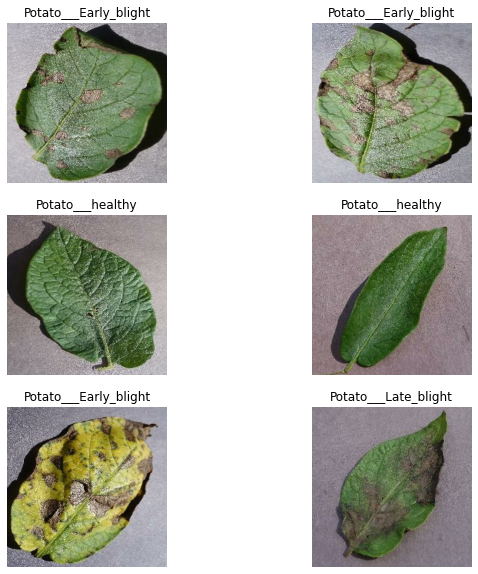

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

In [9]:
# 80-20 (10 validation - 10 test) train test split

In [10]:
train_size = len(dataset)*0.8

In [11]:
train_ds = dataset.take(54)

In [12]:
test_ds = dataset.skip(54)

In [13]:
test_size = len(dataset)*0.1

In [14]:
val_ds = test_ds.take(6)

In [15]:
test_ds = test_ds.skip(6)

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

class Rescaling(tf.keras.layers.Layer):
    """Multiply inputs by `scale` and adds `offset`.
    For instance:
    1. To rescale an input in the `[0, 255]` range
    to be in the `[0, 1]` range, you would pass `scale=1./255`.
    2. To rescale an input in the `[0, 255]` range to be in the `[-1, 1]` 
    range,
    you would pass `scale=1./127.5, offset=-1`.
    The rescaling is applied both during training and inference.
    Input shape:
    Arbitrary.
    Output shape:
    Same as input.
    Arguments:
    scale: Float, the scale to apply to the inputs.
    offset: Float, the offset to apply to the inputs.
    name: A string, the name of the layer.
    """

    def __init__(self, scale, offset=0., name=None, **kwargs):
        self.scale = scale
        self.offset = offset
        super(Rescaling, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        dtype = self._compute_dtype
        scale = tf.cast(self.scale, dtype)
        offset = tf.cast(self.offset, dtype)
        return tf.cast(inputs, dtype) * scale + offset

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
        'scale': self.scale,
        'offset': self.offset,
      }
        base_config = super(Rescaling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [29]:
t

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
resize_and_rescale = tf.keras.Sequential([
    #prediction resize
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(scale=1./255)
    
])

In [37]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255),
    
    layers.RandomFlip("horizontal_and_vertical"),
    #layers.RandomRotation(0.2),
    #layers.experimental.preprocessing.RandomRotation(0.2),
    layers.Conv2D(32,(3,3),activation='relu',
                  input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (32, 256, 256, 3)         0         
                                                                 
 rescaling_6 (Rescaling)     (32, 256, 256, 3)         0         
                                                                 
 random_flip_6 (RandomFlip)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (32, 125, 125, 64)        18496     
                                                      

In [ ]:
tf. __version__

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 91s 2s/step - loss: 0.9060 - accuracy: 0.4959 - val_loss: 0.8676 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 88s 2s/step - loss: 0.8008 - accuracy: 0.6435 - val_loss: 0.6711 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.5520 - accuracy: 0.7656 - val_loss: 0.9061 - val_accuracy: 0.5417
Epoch 4/50
54/54 [==============================] - 79s 1s/step - loss: 0.4356 - accuracy: 0.8044 - val_loss: 0.2640 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 79s 1s/step - loss: 0.2893 - accuracy: 0.8900 - val_loss: 0.2529 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 79s 1s/step - loss: 0.2631 - accuracy: 0.8906 - val_loss: 0.1536 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 78s 1s/step - loss: 0.1851 - accuracy: 0.9242 - val_loss: 0.2108 - val_accuracy: 0.9323
Epoch 8/50
54/54 [==

In [42]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 434ms/step - loss: 0.0472 - accuracy: 0.9844


[0.047225985676050186, 0.984375]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

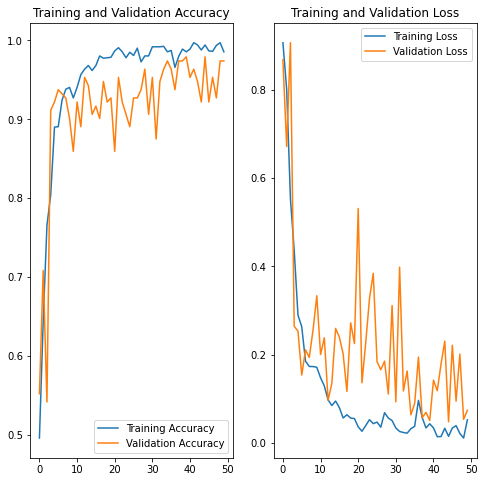

In [49]:
EPOCHS=50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 277ms/step
predicted label: Potato___Early_blight


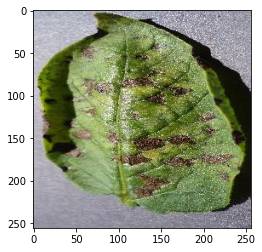

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[1])])

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


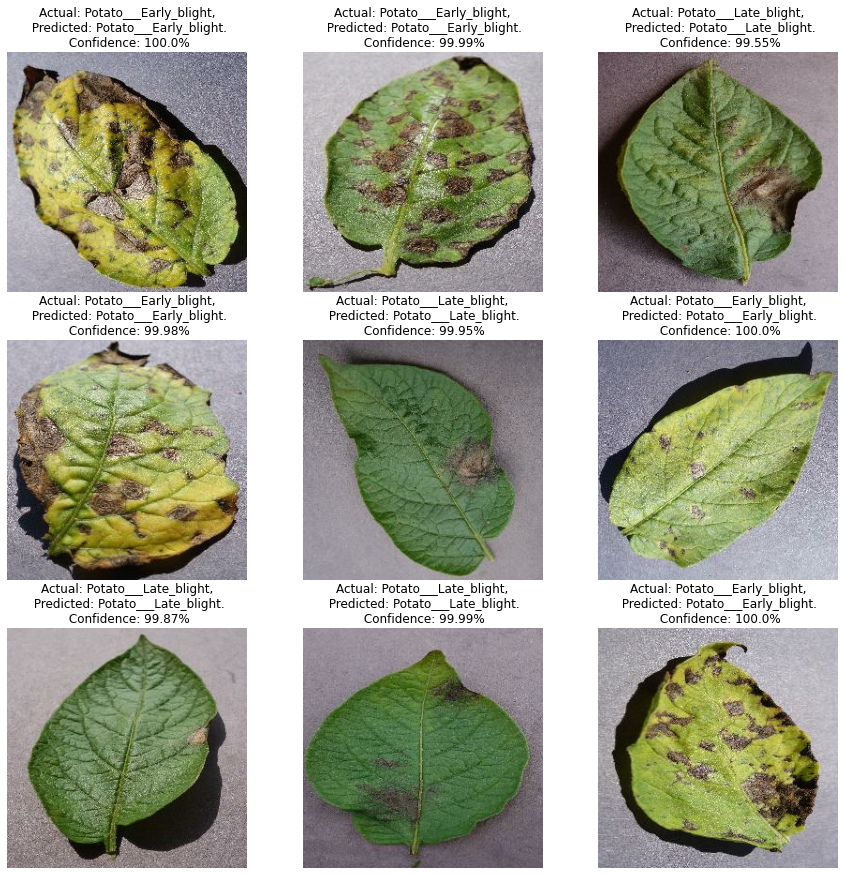

In [69]:


plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")



In [82]:


import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}.h5")


